In [25]:
import database as db
import utils
import numpy as np
from pathlib import Path

%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

Using input device 'Built-in Microphone'
Recording ended
Max mp3:  5456.5
Max mic:  29972


<IPython.core.display.Javascript object>


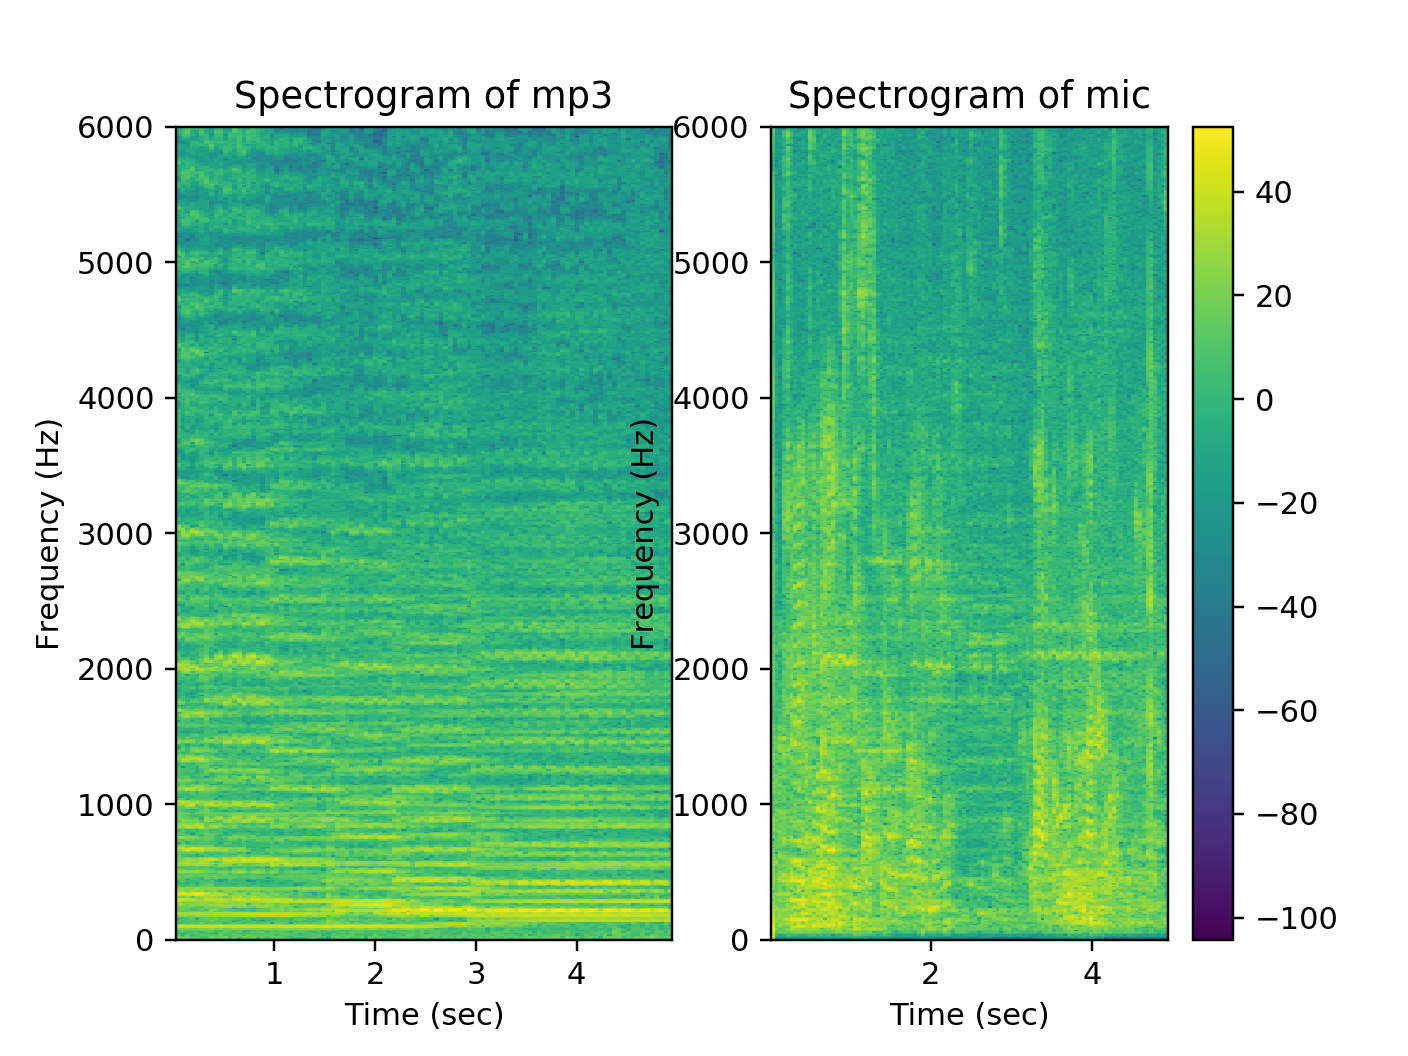

In [32]:
sampling_rate = 44100
mp3 = utils.input_mp3(Path("MP3s/Popper Requiem for three cellos and piano.mp3"))
mp3 = mp3[10*sampling_rate:15*sampling_rate]
mic = utils.input_mic(5)
print("Max mp3: ", np.max(mp3))
print("Max mic: ", np.max(mic))

fig, (ax1, ax2) = plt.subplots(1,2)

S_mp3, freqs, times, im1 = ax1.specgram(mp3, NFFT=4096, Fs=sampling_rate,
                                      window=mlab.window_hanning,
                                      noverlap=4096 // 2)
S_mic, freqs, times, im2 = ax2.specgram(mic, NFFT=4096, Fs=sampling_rate,
                                      window=mlab.window_hanning,
                                      noverlap=4096 // 2)

fig.colorbar(im1)

ax1.set_xlabel("Time (sec)")
ax1.set_ylabel("Frequency (Hz)")
ax1.set_title("Spectrogram of mp3")
ax1.set_ylim(0, 6000);

ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Frequency (Hz)")
ax2.set_title("Spectrogram of mic")
ax2.set_ylim(0, 6000);

<IPython.core.display.Javascript object>


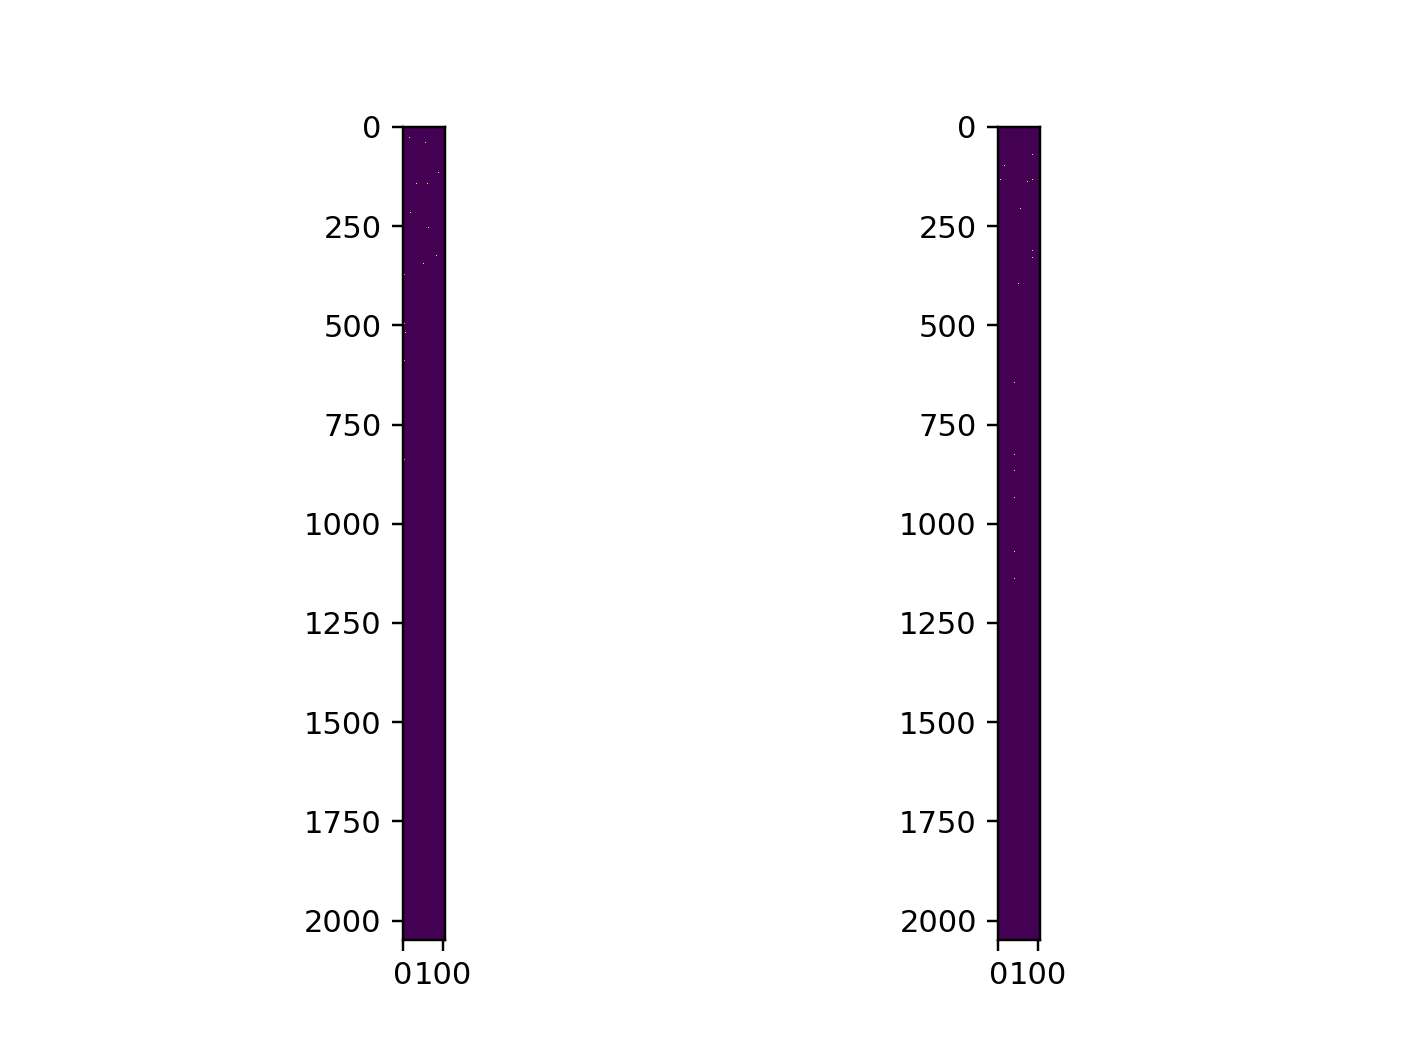

In [33]:
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion, iterate_structure

def find_cutoff(S):
    N = S.size
    count, bin_edges = np.histogram(np.log(S.flatten()), N//2, normed=True)

    cumulative_distr = np.cumsum(count*np.diff(bin_edges))
    
    frac_cut = 0.9
    bin_index_of_cutoff = np.searchsorted(cumulative_distr, frac_cut)
    # given the bin-index, we want the associated log-amplitude value for that bin
    cutoff_log_amplitude = bin_edges[bin_index_of_cutoff]
    return cutoff_log_amplitude

def spectrogram_to_peaks(S):
    """Parameters: 
    S = spectrogram
    fre = frequencies
    ti = times"""

    S = S + 10e-20 # add a really small value to avoid 0s
    cutoff = find_cutoff(S)
    
    fp = generate_binary_structure(2, 2)
    fp = iterate_structure(fp, 10)

    peaks = (S == maximum_filter(S, footprint=fp)) & (np.log(S) > cutoff)
    return peaks

mp3_peaks = spectrogram_to_peaks(S_mp3)
mic_peaks = spectrogram_to_peaks(S_mic)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(mp3_peaks)
ax2.imshow(mic_peaks)